In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
import numba as nb
import numpy as np
import copy
import pickle

In [2]:
@nb.njit(fastmath=True)
def dist(pos1, pos2):
    x = np.array(pos1) - np.array(pos2)
    return np.sqrt(x.dot(x))

In [ ]:
# HUMAN ATTR FORCE WITH 0.1 DENSITY
# Only needed if new data from simulation
# if no new data, e.g. only want to generate the plots, continue to next cells.
forces = np.arange(10.0, 25.1, 0.5)
iterations = range(0,10)

outfluxes = [[] for _ in forces]
avg_velocities = [[] for _ in forces]

for f, force_num in zip(forces, range(len(forces))):
    distance_df = pd.DataFrame()

    print(f)

    for iteration in iterations:
        df = pd.read_csv(f'../data/log/attr_force/HUMAN_ATTR_FORCE_{f:.1f}_{iteration}_density0.1.csv')
        
        gates_excluded = [x for x in df.columns if "gate" not in x]
        
        orig_dist = df[gates_excluded].filter(regex='distance')
        orig_dist = list(orig_dist.iloc[1])
        
        agent_locations = [x for x in gates_excluded if "orig_distance" not in x]
        df = df[agent_locations]
        
        nans = []
        for column in range(1,len(df.columns),2):
            first_nan = df[df.columns[column]].isna().idxmax(1)
            nans.append(first_nan)
        
        while nans.count(0) > 0:
            nans[nans.index(0)] = df.timestep.iat[-1]

        outflux = (len(agent_locations)/2) / max(nans)
        outfluxes[force_num].append(outflux)

        average_velocity = np.array(orig_dist) / np.array(nans)
        avg_velocities[force_num].append(np.nanmean(average_velocity))

        steps = 20
        step = 0

        # every x steps add average distance of all agents
        avg_dist_timestep = []
        timesteps = []
        avg_velo_timestep = []

        # so now for every x steps we get an average distance for one agent to the others
        for index, row in df.iterrows():
            if step % steps == 0:
                average_distances = []

                # avg distance
                for j in range(1, len(row), 2):
                    distance = 0
                    amount_of_distances = 0

                    agent_x = row[j]
                    agent_y = row[j+1]
                    if np.isnan(agent_x) or np.isnan(agent_y):
                        continue

                    for k in range(1, len(row), 2):
                        if row[k] == agent_x or np.isnan(row[k]) or np.isnan(row[k+1]):
                            continue
                        
                        amount_of_distances += 1
                        pos1 = (agent_x, agent_y)
                        pos2 = (row[k], row[k+1])
                        distance += dist(pos1, pos2)
                    
                    if amount_of_distances > 0:
                        average_distance = distance / amount_of_distances
                        average_distances.append(average_distance)   
                
                if len(average_distances) > 0:
                    timesteps.append(step)
                    avg_dist_timestep.append(np.nanmean(average_distances))

                # avg velocity
                velocities = []
                if step >= 20:

                    for q in range(1, len(row), 2):
                        current_x = row[q]
                        current_y = row[q+1]
                        old_x = prev_row[q]
                        old_y = prev_row[q+1]

                        if np.isnan(current_x) or np.isnan(current_y) or np.isnan(old_x) or np.isnan(old_y):
                            continue

                        pos1 = (current_x, current_y)
                        pos2 = (old_x, old_y)

                        avg_velo = dist(pos1, pos2) / steps
                        velocities.append(avg_velo)
                    
                avg_velo_timestep.append(np.nanmean(velocities)) if len(velocities) != 0 else avg_velo_timestep.append(np.nan)
                
                prev_row = row
                
            step += 1
        
        df5 = pd.DataFrame({'timestep':timesteps})
        df6 = pd.DataFrame({f"iteration_{iteration}_avg_dist_timestep":avg_dist_timestep})
        df7 = pd.DataFrame({f"iteration_{iteration}_avg_velo_timestep":avg_velo_timestep})
        distance_df = pd.concat([distance_df, df5, df6, df7], axis=1)

    distance_df.to_csv(f"../data/log2/attr_force/Human_attr_force_{f:.1f}_10_itertations.csv")

In [ ]:
distance_df = distance_df.loc[:,~distance_df.columns.duplicated()]
print(distance_df)

In [ ]:
# run if veloc and outflux need to be saved.
with open("../data/log2/human_attr_force_avg_velocities.txt", "wb") as fp:
    pickle.dump(avg_velocities, fp)
with open("../data/log2/human_attr_force_outfluxes.txt", "wb") as fp:
    pickle.dump(outfluxes, fp)

In [4]:
# run this before plots if you want to use the saved data, otherwise data from 3 cells above is used!!
with open("../data/log2/attr_force/human_attr_force_all_outfluxes.txt", "rb") as fp:
    outfluxes = pickle.load(fp)

with open("../data/log2/attr_force/human_attr_force_all_avg_velocities.txt", "rb") as fp:
    avg_velocities = pickle.load(fp)

[0.61974371 0.00944424]
[[ 5.10858408e-03 -1.36357160e-04]
 [-1.36357160e-04  3.64440074e-06]]


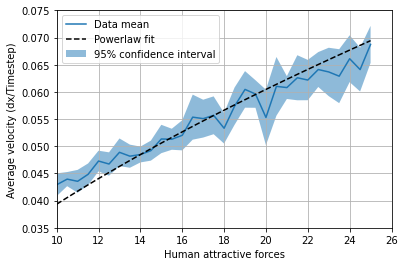

In [5]:
# Extract mean and standard deviation
vel_list = []
vel_err = []

for velocity in avg_velocities:
    mean = np.nanmean(velocity)
    std = 1.96*np.std(velocity)/np.sqrt(10)
    vel_list.append(mean)
    vel_err.append(std)

def func_powerlaw(x, m, c):
    return x**m * c

def func_powerlaw2(x, m, c):
    return x**m * c

# def func_powerlaw(x, m, c0):
#     return c0 + x**m

# def func_exp(x, m, c, c0, b):
#     return c0 + b**(x*m) * c

arange = np.arange(10, 25.1, 0.5)

popt, pcov = curve_fit(func_powerlaw, arange[8:20], vel_list[8:20])
print(popt)
print(pcov)

y1 = func_powerlaw(arange, popt[0], popt[1])

#y2 = func_exp(np.arange(0.01,0.2,0.01), popt[0], popt[1], popt[2], popt[3])
plt.figure(1)
plt.plot(arange, vel_list, label = "Data mean")
plt.plot(arange, y1,ls ="--", color = "black", label = "Powerlaw fit")
plt.fill_between(arange, np.array(vel_list) - np.array(vel_err),np.array(vel_list) + np.array(vel_err), alpha = 0.5, label = "95% confidence interval")
plt.xlim(10, 26)
plt.ylim(.035, .075)
plt.grid()
plt.xlabel("Human attractive forces")
plt.ylabel("Average velocity (dx/Timestep)")
plt.legend()
plt.show()

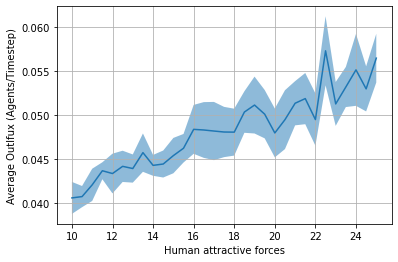

In [6]:
# Extract mean and standard deviation
outflux_list = []
outflux_err = []

for out in outfluxes:
    mean = np.nanmean(out)
    std = 1.96*np.std(out)/np.sqrt(10)
    outflux_list.append(mean)
    outflux_err.append(std)
    
plt.figure(1)
plt.plot(arange, outflux_list)
plt.fill_between(arange, np.array(outflux_list) - np.array(outflux_err),np.array(outflux_list) + np.array(outflux_err), alpha = 0.5)
plt.grid()
plt.xlabel("Human attractive forces")
plt.ylabel("Average Outlfux (Agents/Timestep)")
plt.show()

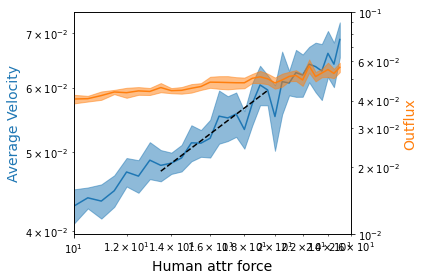

In [7]:
# PLot both in same figure
human_attr_force = arange
fig, ax1 = plt.subplots()

color = 'C0'
ax1.set_xlabel('Human attr force', fontsize=14)
ax1.set_ylabel('Average Velocity', color=color, fontsize=14)
ax1.loglog(human_attr_force, vel_list, label = "Data mean")

plt.plot(arange[7:20], y1[7:20],ls ="--", color = "black", label = "Powerlaw fit")
plt.fill_between(human_attr_force, np.array(vel_list) - np.array(vel_err),np.array(vel_list) + np.array(vel_err), alpha = 0.5, label = "95% confidence interval", color = color)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'C1'
ax2.set_ylabel('Outflux', color=color, fontsize=14) 
ax2.loglog(human_attr_force, outflux_list, color=color)

ax2.fill_between(human_attr_force, np.array(outflux_list) - np.array(outflux_err),np.array(outflux_list) + np.array(outflux_err), alpha = 0.5, color = color)
ax2.tick_params(axis='y')

plt.vlines(0.08, 0, 10, color = "black", ls = ":")
plt.xlim(10,26)
plt.ylim(0.01,0.1)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

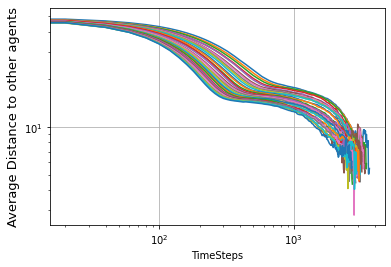

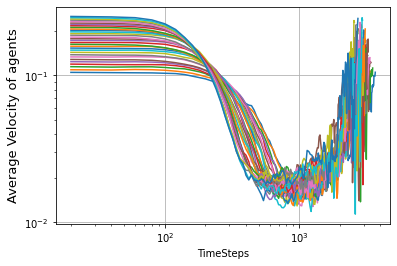

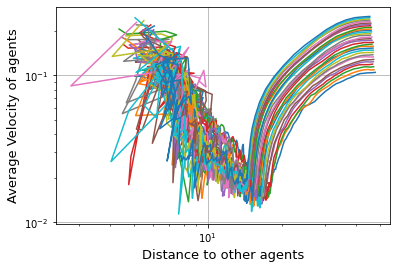

In [8]:
forces = arange

for f in forces:
    df = pd.read_csv(f"../data/log2/attr_force/HUMAN_ATTR_FORCE_{f}_10_itertations.csv")

    distances = [x for x in df.columns if "dist" in x]
    velocities = [x for x in df.columns if "velo" in x]
    df_dist = df[distances]
    df_velo = df[velocities]
    
    dist_means = df_dist.mean(axis=1)
    dist_std = df_dist.std(axis=1)
    velo_means = df_velo.mean(axis=1)
    velo_std = df_velo.std(axis=1)
    
    plt.plot(range(0, int(20*len(dist_means)), 20), dist_means)
    
plt.xlabel("TimeSteps")
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.ylabel("Average Distance to other agents", fontsize = 13)
plt.show()

plt.figure()

for f in forces:
    df = pd.read_csv(f"../data/log2/attr_force/HUMAN_ATTR_FORCE_{f}_10_itertations.csv")

    distances = [x for x in df.columns if "dist" in x]
    velocities = [x for x in df.columns if "velo" in x]
    df_dist = df[distances]
    df_velo = df[velocities]
    
    dist_means = df_dist.mean(axis=1)
    dist_std = df_dist.std(axis=1)
    velo_means = df_velo.mean(axis=1)
    velo_std = df_velo.std(axis=1)
    
    plt.plot(range(0, int(20*len(velo_means)), 20), velo_means)
    
plt.xlabel("TimeSteps")
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.ylabel("Average Velocity of agents", fontsize = 13)
plt.show()

for f in forces:
    df = pd.read_csv(f"../data/log2/attr_force/HUMAN_ATTR_FORCE_{f}_10_itertations.csv")

    distances = [x for x in df.columns if "dist" in x]
    velocities = [x for x in df.columns if "velo" in x]
    df_dist = df[distances]
    df_velo = df[velocities]
    
    dist_means = df_dist.mean(axis=1)
    dist_std = df_dist.std(axis=1)
    velo_means = df_velo.mean(axis=1)
    velo_std = df_velo.std(axis=1)
    
    plt.plot(dist_means, velo_means)
    
plt.xlabel("Distance to other agents", fontsize = 13)
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.ylabel("Average Velocity of agents", fontsize = 13)
plt.show()